# Read the dataset file “labels.csv”
visualizing the data

In [1]:
%matplotlib inline
from os.path import join
import pandas as pd

# relative path
DATA_FILES_PATH = '../Dog-Breed-Classifier/testData/'

# loading labels.csv
INTRO_DF = pd.read_csv(join(DATA_FILES_PATH, 'labels.csv'))

# describe the dataset
INTRO_DF.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


# Breed image distribution

In [2]:
INTRO_DF.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=True).describe()

,id
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


#### Scottish_deerhound being the largest
#### Briard being the smallest

In [3]:
# we can choose from 2 option views

# opition 1
# ax=pd.value_counts(INTRO_DF['breed'],ascending=True).plot(kind='barh',
#                                                        fontsize="40",
#                                                        title=" Dog Distribution",
#                                                        figsize=(50,100))
# ax.set(xlabel="Images per class", ylabel="Classes")
# ax.xaxis.label.set_size(40)
# ax.yaxis.label.set_size(40)
# ax.title.set_size(60)

# opition 2
INTRO_DF["breed"].value_counts().plot.bar(figsize=(20, 10))


NameError: name 'NTRO_DF' is not defined

In [4]:
print()

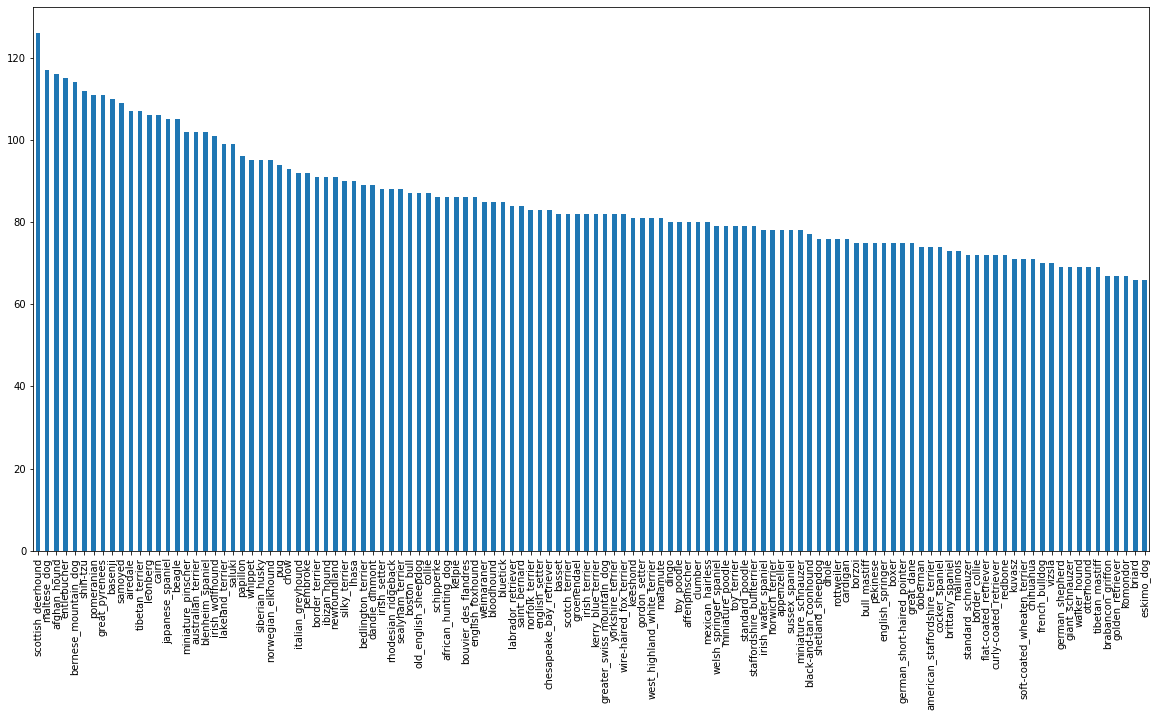

In [5]:
INTRO_DF["breed"].value_counts().plot.bar(figsize=(20, 10))